In [733]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [734]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


## Data Augmentation

### Define Augmentation Function


In [735]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

In [736]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  400
Data setelah augmentasi:  0


## Data Preparation

### Define Preprocessing Function


In [737]:
def resize(img, th, tw):
    h, w = img.shape
    resized = np.zeros((th, tw), dtype=np.uint8)
    
    skala_y = h / th
    skala_x = w / tw
    
    for i in range(th):
        for j in range(tw):
            src_y = int(i * skala_y)
            src_x = int(j * skala_x)
            resized[i, j] = img[src_y, src_x]
    
    return resized

def normalisasi(img):
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val - min_val == 0:
        return np.zeros_like(img, dtype=np.uint8)
    normalized_img = ((img - min_val) / (max_val - min_val)) * 255
    return normalized_img.astype(np.uint8)

def ekualisasi(img):
    hist = np.zeros(256, dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i, j]] += 1

    total_pixels = img.shape[0] * img.shape[1]
    pdf = hist / total_pixels

    cdf = np.zeros(256)
    cdf[0] = pdf[0]
    for i in range(1, 256):
        cdf[i] = cdf[i - 1] + pdf[i]

    cdf_normalized = np.round(cdf * 255).astype(np.uint8)

    ekualisasi_img = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            ekualisasi_img[i, j] = cdf_normalized[img[i, j]]

    return ekualisasi_img

def histogram(frag):
    hist = np.zeros(256)
    img_flat = frag.flatten()

    for i in img_flat:
        hist[i] += 1
        
    hist_y = hist
    hist_x = np.arange(0, len(hist))
    return hist_y, hist_x

def spesifikasi(img, img_ref):
    hist_input = histogram(img)
    hist_ref = histogram(img_ref)

    cdf_input = np.cumsum(hist_input) / np.sum(hist_input)
    cdf_ref = np.cumsum(hist_ref) / np.sum(hist_ref)

    map_hist = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        selisih = np.abs(cdf_input[i] - cdf_ref)
        map_hist[i] = np.argmin(selisih)

    hasil = map_hist[img]
    return hasil

def konvo(img, kernel):
    img_h, img_w = img.shape
    kernel_h, kernel_w = kernel.shape
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2
    pad_img = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    result = np.zeros([img_h, img_w])

    for i in range(img_h):
        for j in range(img_w):
            result[i, j] = np.sum(pad_img[i:i+kernel_h, j:j+kernel_w] * kernel)

    result = (result - result.min()) / (result.max() - result.min()) * 255
    return result.astype(np.uint8)


def op_modus (piksel_values):
    count = {}
    for num in piksel_values:
        if num in count:
            count[num] +=1
        else:
            count[num] = 1

    max_count = 0
    modus = None
    for num in count:
        if count[num] > max_count:
            max_count = count[num]
            modus = num
    return modus

def op_median(piksel_values):
    n = len(piksel_values)
    sorted_piksel = sorted(piksel_values)
    if n % 2 == 0:
        median1 = sorted_piksel[n//2]
        median2 = sorted_piksel[n//2-1]
        median = (median1 + median2)/2
    else:
        median = sorted_piksel[n//2]
    return median

def konvo_modmed(img, kernel, jenis):
    img_h, img_w = img.shape
    kernel_h, kernel_w = kernel.shape
    pad_h = kernel_h //2
    pad_w = kernel_w //2
    pad_img = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    result = np.zeros_like(img)

    for i in range(img_h):
        for j in range (img_w):
            temp = np.zeros(len(kernel)*len(kernel))
            indeks = 0
            for k in range (kernel_h):
                for l in range (kernel_w):
                    temp[indeks] += pad_img[i+k, j+l]
                    indeks+=1
                    if(jenis=="modus"):
                        result[i, j] = op_modus(temp)
                    else:
                        result[i, j] = op_median(temp)
    return result

Rt = np.array([[1,0],
               [0,-1]])

Rk = np.array([[0,1],
               [-1,0]])

Sx = np.array([[-1,0,1],
               [-2,0,2],
               [-1,0,1]])

Sy = np.array([[1,2,1],
               [0,0,0],
               [-1,-2,-1]])

Px = np.array([[-1,0,1],
               [-1,0,1],
               [-1,0,1]])

Py = np.array([[1,1,1],
               [0,0,0],
               [-1,-1,-1]])

kernel_3x3 = np.full((3,3), 1/9)
kernel3x3_empty = np.full((3,3), 0)

def padding_baris(img):
    h, w = img.shape
    img_pad = np.zeros((h, w+1))
    for i in range(h):
        for j in range(w):
            img_pad[i][j] = img[i][j]
    return img_pad

def padding_kolom(img):
    h, w = img.shape
    img_pad = np.zeros((h+1, w))
    for i in range(h):
        for j in range(w):
            img_pad[i][j] = img[i][j]
    return img_pad

def konvo_edge(img, kernel, jenis):
    img_h, img_w = img.shape
    kernel_h, kernel_w = kernel.shape
    pad_h = kernel_h //2
    pad_w = kernel_w //2
    if(jenis!="roberts"):
        padded_img =  np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    else:
        padded_baris = padding_baris(img)
        padded_img = padding_kolom(padded_baris)
    result = np.zeros([img_h, img_w])

    for i in range(img_h):
        for j in range(img_w):
            result[i, j] = np.sum(padded_img[i:i+kernel_h, j:j+kernel_w] * kernel)
    return result

def edge(image, kernelX, kernelY, jenis):
    gradX = konvo_edge(image, kernelX, jenis)
    gradY = konvo_edge(image, kernelY, jenis)

    M = np.sqrt((gradX*gradX)+(gradY*gradY))

    return M.astype(np.uint8)

def threshold(img, batas):
    hasil = np.copy(img)
    hasil[hasil>=batas] = 0
    hasil[hasil<batas] = 255
    return hasil

def erosi(img, kernel):
    h, w = img.shape
    kernel_h, kernel_w = kernel.shape
    center = kernel_h//2
    hasil = np.zeros((h,w))

    for i in range(center, h-center):
        for j in range(center, w-center):
            cocok = True
            for x in range(kernel_h):
                for y in range(kernel_w):
                    if kernel[x, y] == 1 and img[i + x - center, j + y - center] == 0:
                        cocok = False
                        break
                if not cocok:
                    break
            if cocok:
                hasil[i,j] = 255
    return hasil

def dilasi(img, kernel):
    h, w = img.shape
    kernel_h, kernel_w = kernel.shape
    center = kernel_h//2
    hasil = np.zeros((h,w))

    for i in range(center, h-center):
        for j in range(center, w-center):
            if img[i,j] == 255:
                for x in range(kernel_h):
                    for y in range(kernel_w):
                        if kernel[x,y] == 1:
                            hasil[i+x-center, j+y-center] = 255
            else:
                if hasil[i,j] != 255:
                    hasil[i,j] = 0
    return hasil

def opening(img, kernel):
    erosi_result = erosi(img, kernel)
    hasil = dilasi(erosi_result, kernel)
    return hasil

def closing(img, kernel):
    dilasi_result = dilasi(img, kernel)
    hasil = erosi(dilasi_result, kernel)
    return hasil

def gradien_morph(img, kernel):
    dilated = dilasi(img, kernel)
    eroded = erosi(img, kernel)
    gradient = dilated - eroded
    return gradient

kernel_smooth = np.array([[1/10, 1/10, 1/10],
                         [1/10, 1/5, 1/10],
                         [1/10, 1/10, 1/10]])
kernel_sharp = np.array([[1/9, 1/9, 1/9],
                         [1/9, 8/9, 1/9],
                         [1/9, 1/9, 1/9]])
                    

### Preprocessing

In [ ]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)): # Loop through each image and do preprocessing
	img = data[i]
	img = resize(img, 128, 128)
	img = normalisasi(img)
	img = ekualisasi(img)
	img = konvo(img, kernel_3x3)
	img = konvo(img, kernel_3x3)
	img = konvo(img, kernel_3x3)
	img = edge(img, Sx, Sy, "median")

	dataPreprocessed.append(img)

	

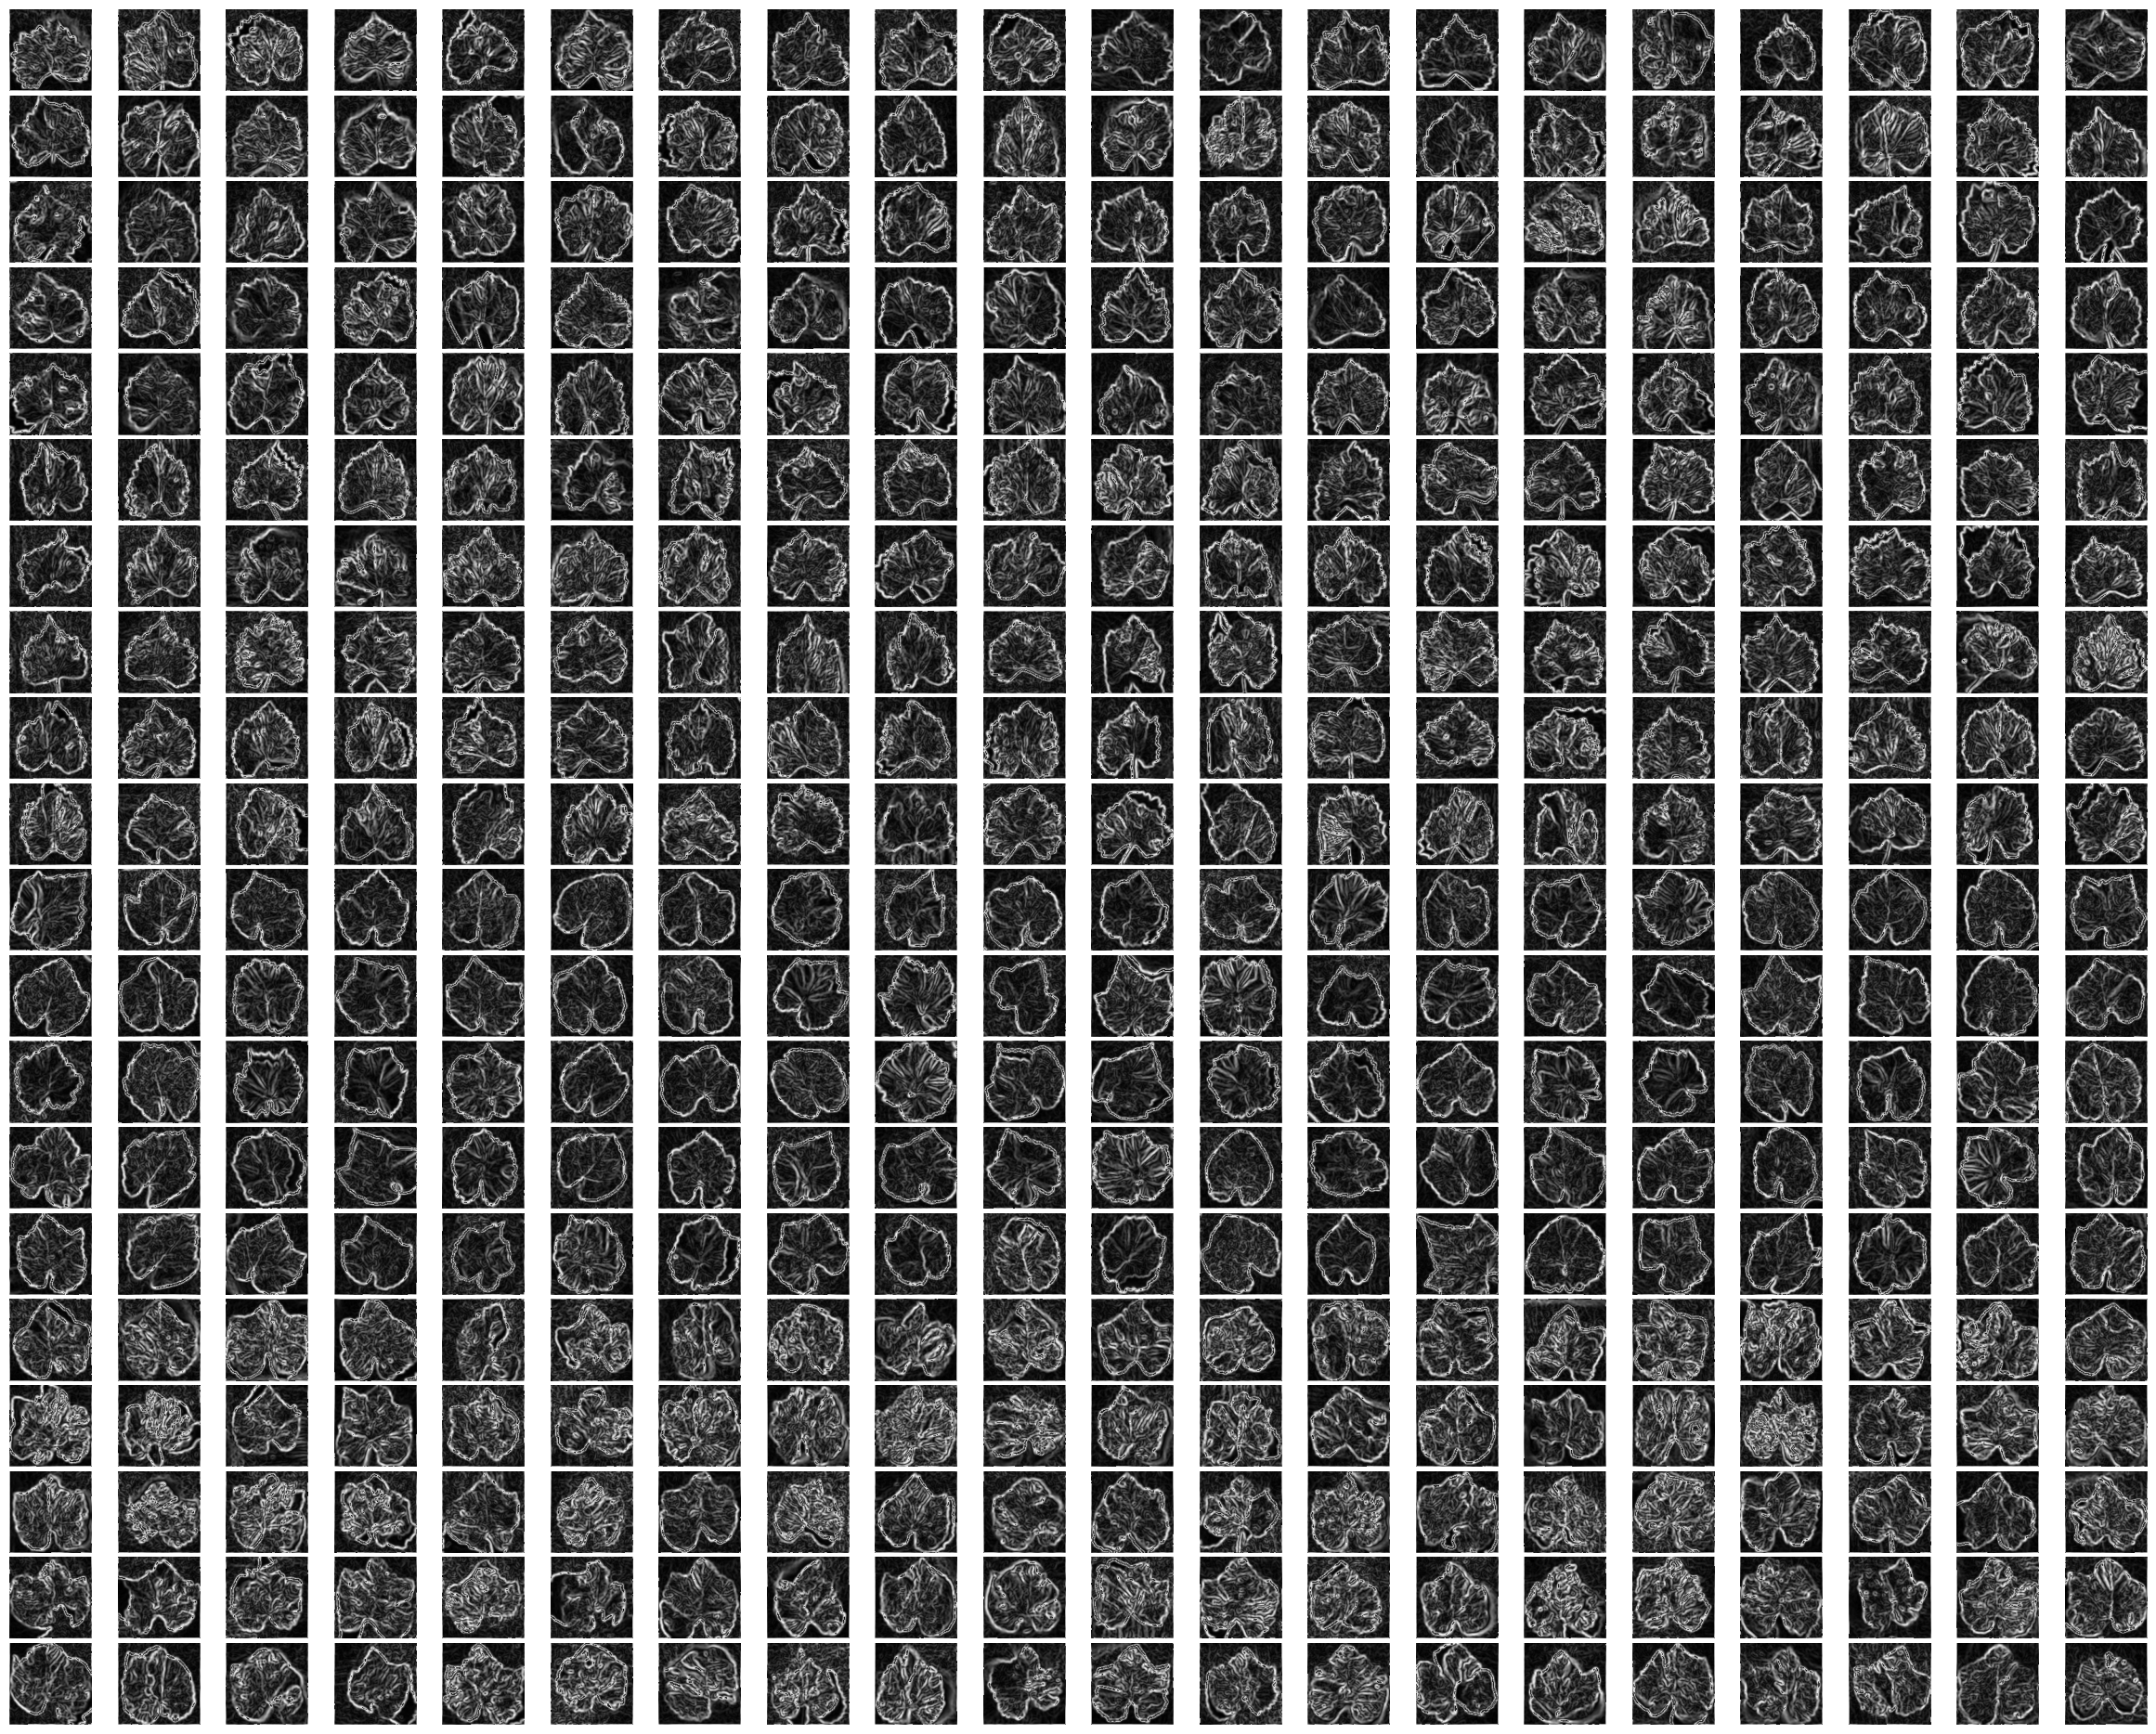

In [1029]:
max_display = 400
display_data = dataPreprocessed[:max_display]

columns = 20
total = len(display_data)
rows = -(-total // columns)

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(30, 24))

axes_list = axes.ravel() if total > 1 else [axes]

for idx in range(rows * columns):
    ax = axes_list[idx]
    if idx < total:
        ax.imshow(display_data[idx], cmap='gray')
    ax.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

### Feature Extraction

In [1030]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [1031]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [1032]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [1033]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [1034]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [1035]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [1036]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [1037]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [1038]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [1039]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [1040]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [1041]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [1042]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [1043]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [1044]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [1045]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [1046]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [1047]:
print("Filename:", len(file_name))
print("Label:", len(labels))
print("Kontras0:", len(Kontras0))
print("Kontras45:", len(Kontras45))
print("Kontras90:", len(Kontras90))
print("Kontras135:", len(Kontras135))
print("Homogeneity0:", len(homogenity0))
print("Homogeneity45:", len(homogenity45))
print("Homogeneity90:", len(homogenity90))
print("Homogeneity135:", len(homogenity135))
print("Entropy0:", len(entropy0))
print("Entropy45:", len(entropy45))
print("Entropy90:", len(entropy90))
print("Entropy135:", len(entropy135))
print("Correlation0:", len(correlation0))
print("Correlation45:", len(correlation45))
print("Correlation90:", len(correlation90))
print("Correlation135:", len(correlation135))


Filename: 400
Label: 400
Kontras0: 400
Kontras45: 400
Kontras90: 400
Kontras135: 400
Homogeneity0: 400
Homogeneity45: 400
Homogeneity90: 400
Homogeneity135: 400
Entropy0: 400
Entropy45: 400
Entropy90: 400
Entropy135: 400
Correlation0: 400
Correlation45: 400
Correlation90: 400
Correlation135: 400


### Write the extraction's results to CSV 

In [1048]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


Filename  \
0    003d09ef-e16c-4e8a-badf-847d46cb3dc0___FAM_B.R...   
1    00cab05d-e87b-4cf6-87d8-284f3ec99626___FAM_B.R...   
2    00cff577-afd4-4e36-ac9c-a52aa6ae5949___FAM_B.R...   
3    02c0e019-97c2-48f5-ac40-90b8789e6288___FAM_B.R...   
4    02f75392-dbad-4ab8-a35d-d391f9d57113___FAM_B.R...   
..                                                 ...   
395  4cd25f42-7cda-4507-a1bd-a03b5f439ef5___FAM_L.B...   
396  4d7ad495-1420-4ac7-9123-f0aa1e828270___FAM_L.B...   
397  4d8aa281-ddb5-4f46-a95c-72a65c59903a___FAM_L.B...   
398  4e32244f-8e20-4788-8c49-93e971113104___FAM_L.B...   
399  4f1d732d-fe6b-423e-9ec5-c901b63e204e___FAM_L.B...   

                                          Label    Contrast0   Contrast45  \
0                             Grape___Black_rot  1472.586061  2286.123070   
1                             Grape___Black_rot  2229.453679  2612.209994   
2                             Grape___Black_rot  1954.924766  2596.349805   
3                             Grape___Black_rot   870.894439  1867.157790   
4                             Grape___Black_rot  1343.768701  2157.053816   
..                                          ...          ...          ...   
395  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  1953.871001  2351.034410   
396  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  1138.418430  1516.662781   
397  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  1434.654343  1953.686837   
398  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   731.673597  1440.678095   
399  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  1046.326772  1691.399343   

      Contrast90  Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  \
0    1808.424274  2652.978238      0.099537       0.081557       0.098849   
1    1857.603100  3152.411743      0.067334       0.055280       0.073667   
2    1656.627830  2761.838676      0.075488       0.058564       0.078997   
3    1346.492803  1830.502635      0.104543       0.071224       0.090306   
4    1309.356484  1912.859632      0.089618       0.063883       0.084839   
..           ...          ...           ...            ...            ...   
395  1498.770731  2537.028830      0.086818       0.073579       0.088416   
396   854.784449  1800.237646      0.095415       0.081417       0.096463   
397  1262.880475  2236.073656      0.069326       0.059524       0.084677   
398   795.865527  1207.636617      0.100090       0.072316       0.104280   
399  1109.212229  1758.860686      0.100757       0.076412       0.099856   

     Homogeneity135  ...     ASM90    ASM135   Energy0  Energy45  Energy90  \
0          0.071305  ...  0.000265  0.000203  0.016644  0.014864  0.016266   
1          0.049068  ...  0.000168  0.000126  0.012608  0.011807  0.012962   
2          0.057463  ...  0.000196  0.000153  0.013804  0.012424  0.014002   
3          0.076359  ...  0.000305  0.000266  0.018581  0.016063  0.017460   
4          0.071274  ...  0.000272  0.000229  0.016822  0.014836  0.016507   
..              ...  ...       ...       ...       ...       ...       ...   
395        0.063783  ...  0.000228  0.000170  0.014725  0.013719  0.015101   
396        0.063998  ...  0.000236  0.000170  0.015270  0.014108  0.015368   
397        0.052857  ...  0.000205  0.000152  0.013681  0.012741  0.014328   
398        0.077201  ...  0.000272  0.000218  0.016218  0.014220  0.016486   
399        0.070471  ...  0.000279  0.000211  0.016566  0.015064  0.016694   

     Energy135  Correlation0  Correlation45  Correlation90  Correlation135  
0     0.014232      0.742354       0.588066       0.681320        0.521784  
1     0.011239      0.656683       0.591839       0.717040        0.507439  
2     0.012365      0.715451       0.620659       0.761334        0.596474  
3     0.016323      0.849546       0.665208       0.763567        0.671907  
4     0.015141      0.773151       0.627283       0.778513        0.669474  
..         ...           ...            ...            ...             ...  
395   0.013042      0.6

### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

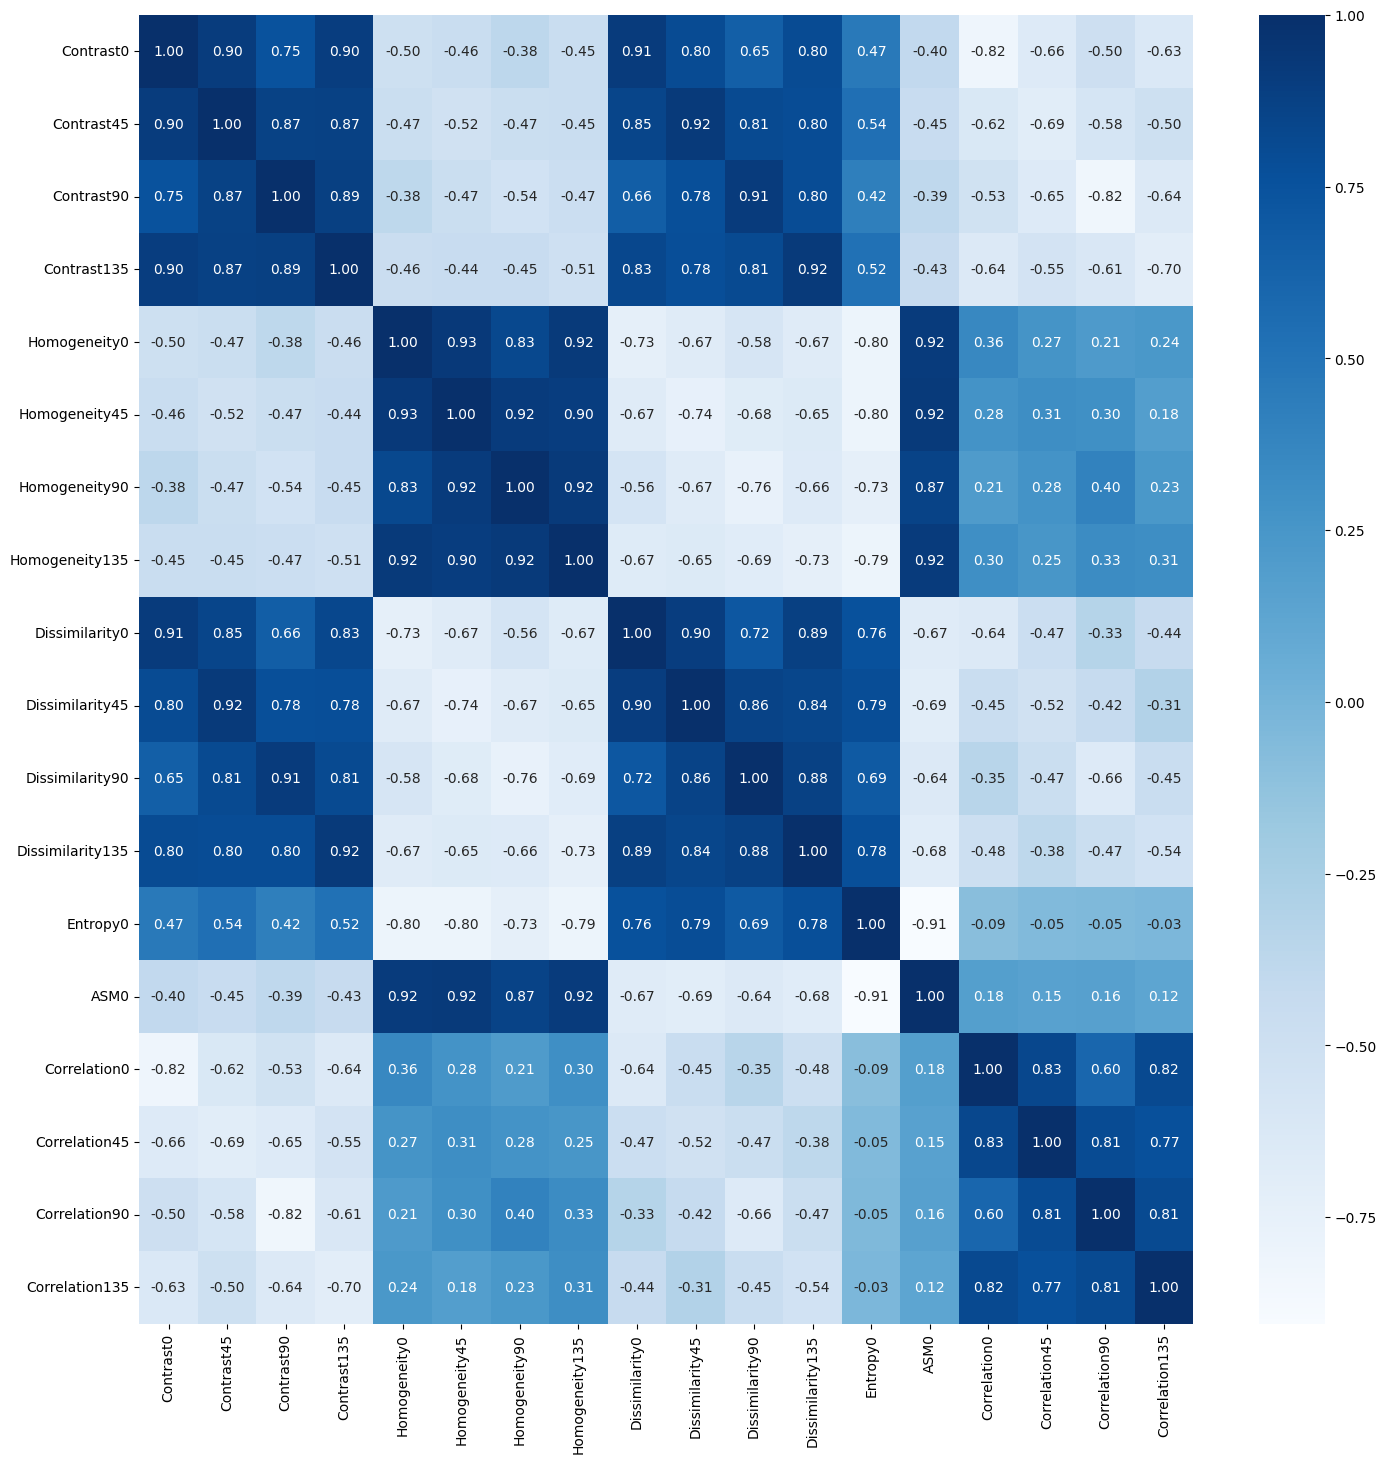

In [1049]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [1078]:
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(280, 18)
(120, 18)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [1079]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [1080]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=7, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [1081]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.95      0.98      0.97        63
              Grape___Esca_(Black_Measles)       0.97      1.00      0.99        75
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.99      0.94      0.96        72
                           Grape___healthy       0.99      0.97      0.98        70

                                  accuracy                           0.97       280
                                 macro avg       0.97      0.98      0.97       280
                              weighted avg       0.98      0.97      0.97       280

[[62  0  0  1]
 [ 0 75  0  0]
 [ 2  2 68  0]
 [ 1  0  1 68]]
Accuracy: 0.975

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.64      0.43      0.52        37
              Grape___Esca_(B

### Train SVM Classifier

In [1082]:
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.48      0.40      0.43        63
              Grape___Esca_(Black_Measles)       0.54      0.75      0.63        75
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.84      0.67      0.74        72
                           Grape___healthy       0.87      0.83      0.85        70

                                  accuracy                           0.67       280
                                 macro avg       0.68      0.66      0.66       280
                              weighted avg       0.69      0.67      0.67       280

[[25 28  5  5]
 [15 56  4  0]
 [ 7 13 48  4]
 [ 5  7  0 58]]
Accuracy: 0.6678571428571428

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.63      0.32      0.43        37
              G

### Train KNN Classifier

In [1083]:
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.55      0.76      0.64        63
              Grape___Esca_(Black_Measles)       0.65      0.68      0.67        75
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.82      0.57      0.67        72
                           Grape___healthy       0.88      0.80      0.84        70

                                  accuracy                           0.70       280
                                 macro avg       0.72      0.70      0.70       280
                              weighted avg       0.73      0.70      0.70       280

[[48  6  5  4]
 [20 51  4  0]
 [12 15 41  4]
 [ 8  6  0 56]]
Accuracy: 0.7

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.58      0.57      0.58        37
              Grape___Esca_(Bl

## Evaluation With Confusion Matrix

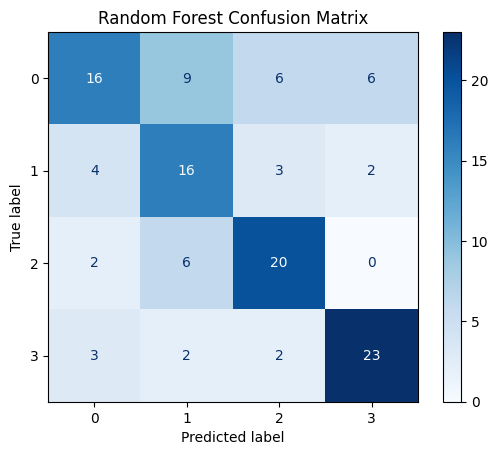

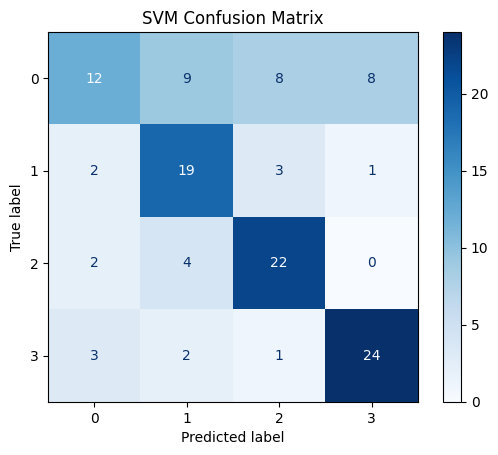

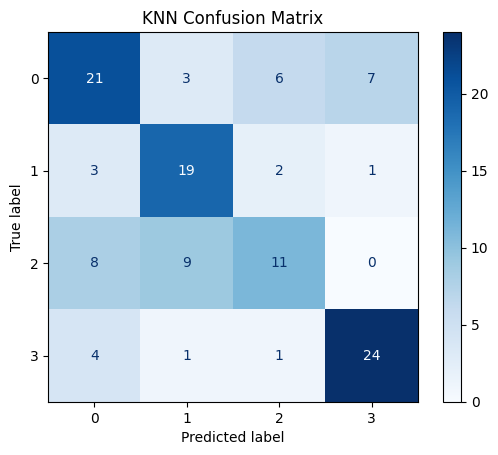

In [1084]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")